In [3]:
!pip uninstall -y numpy pmdarima


Found existing installation: numpy 2.2.5
Uninstalling numpy-2.2.5:
  Successfully uninstalled numpy-2.2.5
Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4


In [4]:
!pip install numpy==1.24.4 pmdarima==2.0.4


  Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 82.3 MB/s eta 0:00:00
Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.1 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have n

In [1]:
!pip install vaderSentiment


In [2]:
# Data wrangling
import pandas as pd
import numpy as np

# Visualization
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Time series
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import auto_arima

# Prophet
from prophet import Prophet

# Warnings
import warnings
warnings.filterwarnings("ignore")


In [5]:
df1 = pd.read_csv("dataset4.1.csv")
df2 = pd.read_csv("dataset4.csv")


In [6]:
print("df1 columns:", df1.columns.tolist())
print("df2 columns:", df2.columns.tolist())


df1 columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Stock Name']
df2 columns: ['Date', 'Tweet', 'Stock Name', 'Company Name']


In [7]:
# Fix df2 (Tweets)
df2.columns = df2.columns.str.strip().str.lower()
df2.rename(columns={'date': 'timestamp', 'tweet': 'text'}, inplace=True)

# Drop rows with missing timestamp or text
df2.dropna(subset=['timestamp', 'text'], inplace=True)

# Fix timestamp format
df2['timestamp'] = pd.to_datetime(df2['timestamp'], errors='coerce')
df2 = df2.dropna(subset=['timestamp'])

# Preview cleaned tweets
print(df2[['timestamp', 'text']].head())


                  timestamp                                               text
0 2022-09-29 23:41:16+00:00  Mainstream media has done an amazing job at br...
1 2022-09-29 23:24:43+00:00  Tesla delivery estimates are at around 364k fr...
2 2022-09-29 23:18:08+00:00  3/ Even if I include 63.0M unvested RSUs as of...
3 2022-09-29 22:40:07+00:00  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...
4 2022-09-29 22:27:05+00:00  @RealDanODowd @Tesla Stop trying to kill kids,...


In [8]:
# Basic structure
print(df2.info())
print(df2.describe(include='all'))

# Peek at the data
df2[['timestamp', 'text']].sample(5, random_state=42)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80793 entries, 0 to 80792
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   timestamp     80793 non-null  datetime64[ns, UTC]
 1   text          80793 non-null  object             
 2   stock name    80793 non-null  object             
 3   company name  80793 non-null  object             
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 2.5+ MB
None
                                  timestamp                          text  \
count                                 80793                         80793   
unique                                  NaN                         64479   
top                                     NaN  $TSLA will triple in 2022 🚀🌕   
freq                                    NaN                            25   
mean    2022-03-19 16:12:15.738492160+00:00                           NaN   
min               2021-09-30 00

,timestamp,text
39068,2022-04-28 23:11:41+00:00,One more $AMZN tweet. \nFolks it's this simple...
69282,2022-02-17 18:23:52+00:00,@PathToLCS @Damonte so tsm is just shit in eve...
42501,2022-06-10 01:13:56+00:00,Here's the intro of today's #MarketOutlook vid...
76170,2021-10-25 16:15:53+00:00,"Blue Origin is partnering with Sierra Space, B..."
18603,2022-03-17 04:45:38+00:00,Don't tell Elon but I already know the plan: h...


In [9]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # URLs
    text = re.sub(r'@\w+|#\w+', '', text)  # Mentions & Hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Punctuation & Numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Extra whitespace
    return text

df2['clean_text'] = df2['text'].apply(clean_text)


In [10]:
df2 = df2.sort_values(by='timestamp')
df2 = df2.drop_duplicates(subset='clean_text')  # Avoid repeated spammy tweets


In [11]:
#Sentiment Generation Using VADER

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Apply VADER to cleaned text
df2['sentiment'] = df2['clean_text'].apply(lambda x: sia.polarity_scores(x)['compound'])


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [12]:
# Ensure timestamp is datetime
df2['timestamp'] = pd.to_datetime(df2['timestamp'], errors='coerce')

# Set timestamp as index
df2.set_index('timestamp', inplace=True)

# Daily sentiment average
daily_sentiment = df2['sentiment'].resample('D').mean().dropna()

# Daily tweet count (for volume tracking)
daily_volume = df2['clean_text'].resample('D').count()


In [13]:
# Merge sentiment and volume
ts_df = pd.concat([daily_sentiment, daily_volume], axis=1)
ts_df.columns = ['avg_sentiment', 'tweet_volume']
ts_df.dropna(inplace=True)

print(ts_df.head())


                           avg_sentiment  tweet_volume
timestamp                                             
2021-09-30 00:00:00+00:00       0.290045           161
2021-10-01 00:00:00+00:00       0.219350           191
2021-10-02 00:00:00+00:00       0.230365           147
2021-10-03 00:00:00+00:00       0.265915            94
2021-10-04 00:00:00+00:00       0.101495           237


In [14]:
#Mini dashboard
#sentiment over time
fig_sentiment = px.line(
    ts_df,
    y='avg_sentiment',
    title='📈 Average Daily Sentiment Over Time',
    labels={'avg_sentiment': 'Average Sentiment', 'index': 'Date'}
)
fig_sentiment.update_layout(template='plotly_dark')
fig_sentiment.show()


In [15]:
#tweet volume
fig_volume = px.bar(
    ts_df,
    y='tweet_volume',
    title='🗣️ Daily Tweet Volume Over Time',
    labels={'tweet_volume': 'Number of Tweets', 'index': 'Date'},
    color_discrete_sequence=['#636EFA']
)
fig_volume.update_layout(template='plotly_dark')
fig_volume.show()


In [17]:
#Combo Chart (Dual Axis – Sentiment + Volume)

fig_combo = go.Figure()

# Sentiment Line
fig_combo.add_trace(go.Scatter(
    x=ts_df.index,
    y=ts_df['avg_sentiment'],
    name='Average Sentiment',
    yaxis='y1',
    line=dict(color='orange')
))

# Tweet Volume Bar
fig_combo.add_trace(go.Bar(
    x=ts_df.index,
    y=ts_df['tweet_volume'],
    name='Tweet Volume',
    yaxis='y2',
    opacity=0.6,
    marker_color='deepskyblue'
))

fig_combo.update_layout(
    title=' Daily Sentiment vs Tweet Volume',
    yaxis=dict(title='Average Sentiment'),
    yaxis2=dict(
        title='Tweet Volume',
        overlaying='y',
        side='right'
    ),
    xaxis=dict(title='Date'),
    template='plotly_dark',
    legend=dict(x=0.01, y=0.99),
    height=500
)

fig_combo.show()


In [18]:
#PREP FOR ARIMA


In [19]:
#ADF TEST

from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    print(f'🔍 ADF Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', 'Num of Observations Used']
    out = dict(zip(labels, result[:4]))
    for key, val in out.items():
        print(f"{key} : {val}")
    for key, val in result[4].items():
        print(f'Critical Value ({key}) : {val}')
    print('✔️ Stationary' if result[1] < 0.05 else '❌ Non-Stationary')

# Run ADF on avg_sentiment
adf_test(ts_df['avg_sentiment'], title='Average Sentiment')


🔍 ADF Test: Average Sentiment
ADF Statistic : -4.3734449978782965
p-value : 0.0003306543914909393
# Lags Used : 6
Num of Observations Used : 358
Critical Value (1%) : -3.448748905151901
Critical Value (5%) : -2.8696473721448728
Critical Value (10%) : -2.5710891239349585
✔️ Stationary


In [21]:
ts_df['sentiment_diff'] = ts_df['avg_sentiment'].diff()
ts_df.dropna(inplace=True)


In [22]:
adf_test(ts_df['sentiment_diff'], title='Differenced Sentiment')


🔍 ADF Test: Differenced Sentiment
ADF Statistic : -9.150965618096498
p-value : 2.6873194254912696e-15
# Lags Used : 11
Num of Observations Used : 352
Critical Value (1%) : -3.4490648539347544
Critical Value (5%) : -2.8697861692116478
Critical Value (10%) : -2.5711631253228306
✔️ Stationary


In [23]:
sentiment_series = ts_df['sentiment_diff']
sentiment_series = sentiment_series.dropna()


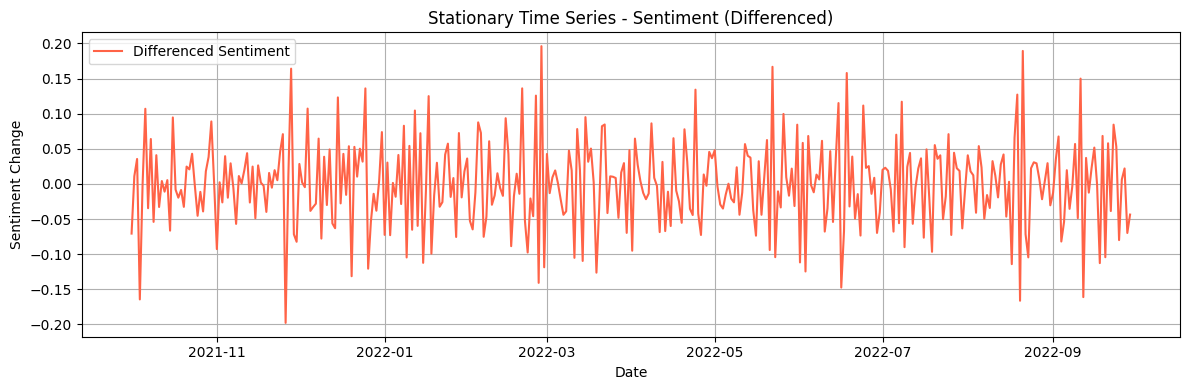

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(sentiment_series, label='Differenced Sentiment', color='tomato')
plt.title("Stationary Time Series - Sentiment (Differenced)")
plt.xlabel("Date")
plt.ylabel("Sentiment Change")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
#TRAINING OF ARIMA

In [69]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA
model_arima = ARIMA(sentiment_series, order=(1, 0, 1))  # (p,d,q)
model_arima_fit = model_arima.fit()

# Summary
print(model_arima_fit.summary())


                               SARIMAX Results                                
Dep. Variable:         sentiment_diff   No. Observations:                  364
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 577.541
Date:                Fri, 25 Apr 2025   AIC                          -1147.081
Time:                        02:16:16   BIC                          -1131.493
Sample:                    10-01-2021   HQIC                         -1140.885
                         - 09-29-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.000     -1.091      0.275      -0.000    9.85e-05
ar.L1          0.2282      0.050      4.562      0.000       0.130       0.326
ma.L1         -0.9692      0.015    -66.017      0.0

In [70]:
n_steps = 30
forecast_arima = model_arima_fit.forecast(steps=n_steps)
forecast_arima.index = pd.date_range(start=sentiment_series.index[-1], periods=n_steps+1, freq='D')[1:]

# Convert to DataFrame
forecast_arima_df = forecast_arima.to_frame(name='forecast')


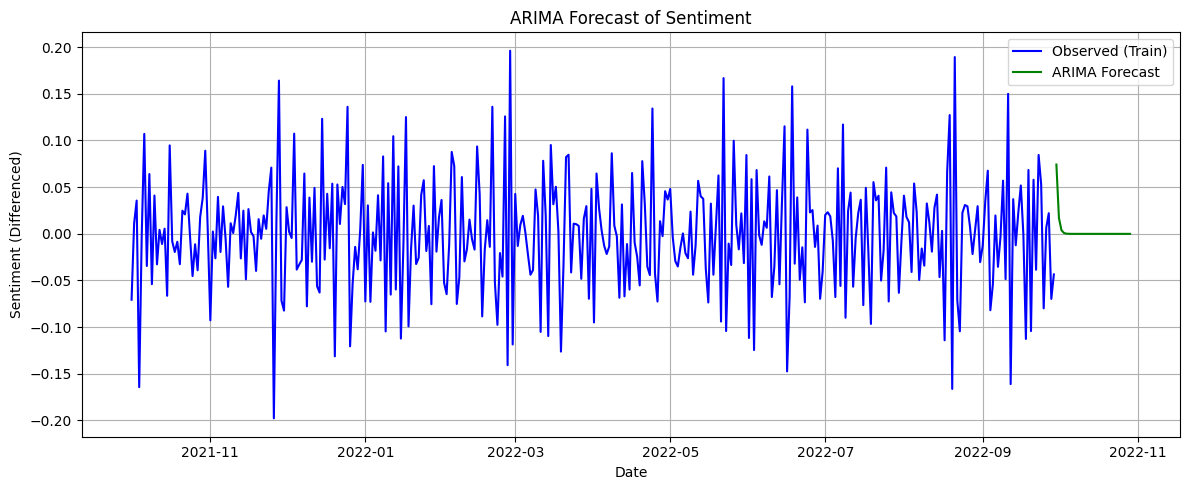

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(sentiment_series, label='Observed (Train)', color='blue')
plt.plot(forecast_arima_df, label='ARIMA Forecast', color='green')
plt.title('ARIMA Forecast of Sentiment')
plt.xlabel('Date')
plt.ylabel('Sentiment (Differenced)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [72]:
import joblib

# Save ARIMA model
joblib.dump(model_arima_fit, 'arima_sentiment_model.pkl')
print(" ARIMA model saved as 'arima_sentiment_model.pkl'")


 ARIMA model saved as 'arima_sentiment_model.pkl'


In [73]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Create pseudo ground truth for evaluation (last N points of original series)
true_values = sentiment_series[-30:]
predicted_values = forecast_arima[:30]

# Align index just in case
predicted_values.index = true_values.index

# Metrics
mse = mean_squared_error(true_values, predicted_values)
mae = mean_absolute_error(true_values, predicted_values)
rmse = np.sqrt(mse)

print(f"""
 ARIMA Evaluation:
- MAE:  {mae:.4f}
- MSE:  {mse:.4f}
- RMSE: {rmse:.4f}
""")



 ARIMA Evaluation:
- MAE:  0.0570
- MSE:  0.0048
- RMSE: 0.0693



In [25]:
#PREP FOR PROPHET

In [74]:
#Train Prophet Model

In [85]:
# Rebuild from the clean time series DataFrame
prophet_df = ts_df[['avg_sentiment']].reset_index()
prophet_df.columns = ['ds', 'y']  # Prophet requires these names

# Ensure datetime and drop timezone
prophet_df['ds'] = pd.to_datetime(prophet_df['ds']).dt.tz_localize(None)

print(prophet_df.head())  # Sanity check
print(prophet_df.columns)  # ['ds', 'y']


          ds         y
0 2021-10-01  0.219350
1 2021-10-02  0.230365
2 2021-10-03  0.265915
3 2021-10-04  0.101495
4 2021-10-05  0.100500
Index(['ds', 'y'], dtype='object')


In [86]:
from prophet import Prophet

# Instantiate and fit
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(prophet_df)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqrwhwqec/6oy59g0n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqrwhwqec/3rjfuz_w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5564', 'data', 'file=/tmp/tmpqrwhwqec/6oy59g0n.json', 'init=/tmp/tmpqrwhwqec/3rjfuz_w.json', 'output', 'file=/tmp/tmpqrwhwqec/prophet_modelejvnlw2o/prophet_model-20250425022233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:22:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:22:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [87]:
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

# Confirm that 'ds' exists now
print(forecast.columns)


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


In [82]:
print(prophet_df.columns)


Index(['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


In [76]:
# Create future dataframe (30 days into the future)
future = prophet_model.make_future_dataframe(periods=30)

# Predict using the trained Prophet model
forecast_prophet = prophet_model.predict(future)


In [88]:
from prophet.plot import plot_plotly

fig1 = plot_plotly(prophet_model, forecast)
fig1.update_layout(title='Prophet Sentiment Forecast',
                   xaxis_title='Date',
                   yaxis_title='Predicted Sentiment Score')
fig1.show()


In [89]:
from prophet.plot import plot_components_plotly

fig2 = plot_components_plotly(prophet_model, forecast)
fig2.show()


In [90]:
import plotly.graph_objects as go

fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=prophet_df['ds'],
    y=prophet_df['y'],
    mode='lines',
    name='Actual Sentiment',
    line=dict(color='royalblue')
))

# Forecasted values
fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat'],
    mode='lines+markers',
    name='Forecasted Sentiment',
    line=dict(color='orange', dash='dot')
))

fig.update_layout(title='Actual vs Forecasted Sentiment (Prophet)',
                  xaxis_title='Date',
                  yaxis_title='Sentiment Score')
fig.show()


In [91]:
# Align actual vs predicted for Prophet
prophet_pred = forecast_prophet.set_index('ds')['yhat'][-30:]
true_values = sentiment_series[-30:]
prophet_pred.index = true_values.index

# Evaluation
mse_prophet = mean_squared_error(true_values, prophet_pred)
mae_prophet = mean_absolute_error(true_values, prophet_pred)
rmse_prophet = np.sqrt(mse_prophet)

print(f"""
 Prophet Evaluation:
- MAE:  {mae_prophet:.4f}
- MSE:  {mse_prophet:.4f}
- RMSE: {rmse_prophet:.4f}
""")



 Prophet Evaluation:
- MAE:  0.1696
- MSE:  0.0328
- RMSE: 0.1812



In [93]:
#DASHBOARD

In [97]:
print(comparison_df.columns)


Index(['ARIMA_Predicted', 'Prophet_Predicted'], dtype='object')


In [98]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(comparison_df['Prophet_Predicted'], comparison_df['ARIMA_Predicted']))
mae = mean_absolute_error(comparison_df['Prophet_Predicted'], comparison_df['ARIMA_Predicted'])
mape = np.mean(np.abs((comparison_df['Prophet_Predicted'] - comparison_df['ARIMA_Predicted']) / comparison_df['ARIMA_Predicted'])) * 100


In [99]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=1,
    row_heights=[0.8, 0.2],
    shared_xaxes=True,
    vertical_spacing=0.1,
    specs=[[{"type": "scatter"}],
           [{"type": "table"}]]
)

# Prophet Forecast
fig.add_trace(go.Scatter(
    x=comparison_df.index,
    y=comparison_df['Prophet_Predicted'],
    mode='lines+markers',
    name='Prophet Forecast',
    line=dict(color='darkorange', dash='dot'),
    hovertemplate='Date: %{x}<br>Sentiment: %{y:.2f}<extra>Prophet</extra>'
), row=1, col=1)

# ARIMA Forecast
fig.add_trace(go.Scatter(
    x=comparison_df.index,
    y=comparison_df['ARIMA_Predicted'],
    mode='lines+markers',
    name='ARIMA Forecast',
    line=dict(color='royalblue'),
    hovertemplate='Date: %{x}<br>Sentiment: %{y:.2f}<extra>ARIMA</extra>'
), row=1, col=1)

# Error metrics table
fig.add_trace(go.Table(
    header=dict(values=["Metric", "Value"], fill_color='paleturquoise', align='left'),
    cells=dict(values=[
        ["RMSE", "MAE", "MAPE"],
        [f"{rmse:.4f}", f"{mae:.4f}", f"{mape:.2f}%"]
    ],
    fill_color='lavender',
    align='left')
), row=2, col=1)

# Layout
fig.update_layout(
    height=700,
    title_text="📊 Prophet vs ARIMA: Sentiment Forecast Battle Royale",
    title_font=dict(size=22),
    showlegend=True,
    legend=dict(x=0.5, y=1.15, orientation="h", xanchor="center"),
    template='plotly_dark',
    margin=dict(t=100, l=20, r=20, b=20),
)

fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Sentiment Score", row=1, col=1)

fig.show()
